In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pylab as plt

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
import optuna
from oanda_bot import Bot

In [41]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C
#         self.units = 1000 # currency unit (default=10000)
#         self.take_profit = 50 # take profit pips (default=0 take profit none)
#         self.stop_loss = 20 # stop loss pips (default=0 stop loss none)

    def backtest(
            self, *, from_date: str = "", to_date: str = "", filename: str = ""
        ) -> None:
            csv = "{}-{}-{}-{}.csv".format(
                self.instrument, self.granularity, from_date, to_date
            )
            if os.path.exists(csv):
                self.df = pd.read_csv(
                    csv, index_col=0, parse_dates=True, infer_datetime_format=True
                )
            else:
                self._candles(from_date=from_date, to_date=to_date)
                if from_date != "" and to_date != "":
                    self.df.to_csv(csv)
            self.strategy()
            o = self.df.O.values
            L = self.df.L.values
            h = self.df.H.values
            N = len(self.df)
            long_trade = np.zeros(N)
            short_trade = np.zeros(N)

            # buy entry
            buy_entry_s = np.hstack((False, self.buy_entry[:-1]))  # shift
            long_trade[buy_entry_s] = o[buy_entry_s]
            # buy exit
            buy_exit_s = np.hstack((False, self.buy_exit[:-2], True))  # shift
            long_trade[buy_exit_s] = -o[buy_exit_s]
            # sell entry
            sell_entry_s = np.hstack((False, self.sell_entry[:-1]))  # shift
            short_trade[sell_entry_s] = o[sell_entry_s]
            # sell exit
            sell_exit_s = np.hstack((False, self.sell_exit[:-2], True))  # shift
            short_trade[sell_exit_s] = -o[sell_exit_s]

            long_pl = pd.Series(np.zeros(N))  # profit/loss of buy position
            short_pl = pd.Series(np.zeros(N))  # profit/loss of sell position
            buy_price = sell_price = 0
            long_rr = []  # long return rate
            short_rr = []  # short return rate
            stop_loss = take_profit = 0

            for i in range(1, N):
                # buy entry
                if long_trade[i] > 0:
                    if buy_price == 0:
                        buy_price = long_trade[i]
                        short_trade[i] = -buy_price  # sell exit
                    else:
                        long_trade[i] = 0

                # sell entry
                if short_trade[i] > 0:
                    if sell_price == 0:
                        sell_price = short_trade[i]
                        long_trade[i] = -sell_price  # buy exit
                    else:
                        short_trade[i] = 0

                # buy exit
                if long_trade[i] < 0:
                    if buy_price != 0:
                        long_pl[i] = (
                            -(buy_price + long_trade[i]) * self.units
                        )  # profit/loss fixed
                        long_rr.append(
                            round(long_pl[i] / buy_price * 100, 2)
                        )  # long return rate
                        buy_price = 0
                    else:
                        long_trade[i] = 0

                # sell exit
                if short_trade[i] < 0:
                    if sell_price != 0:
                        short_pl[i] = (
                            sell_price + short_trade[i]
                        ) * self.units  # profit/loss fixed
                        short_rr.append(
                            round(short_pl[i] / sell_price * 100, 2)
                        )  # short return rate
                        sell_price = 0
                    else:
                        short_trade[i] = 0

                # close buy position with stop loss
                if buy_price != 0 and self.stop_loss > 0:
                    stop_price = buy_price - self.stop_loss * self.point
                    if L[i] <= stop_price:
                        long_trade[i] = -stop_price
                        long_pl[i] = (
                            -(buy_price + long_trade[i]) * self.units
                        )  # profit/loss fixed
                        long_rr.append(
                            round(long_pl[i] / buy_price * 100, 2)
                        )  # long return rate
                        buy_price = 0
                        stop_loss += 1

                # close buy positon with take profit
                if buy_price != 0 and self.take_profit > 0:
                    limit_price = buy_price + self.take_profit * self.point
                    if h[i] >= limit_price:
                        long_trade[i] = -limit_price
                        long_pl[i] = (
                            -(buy_price + long_trade[i]) * self.units
                        )  # profit/loss fixed
                        long_rr.append(
                            round(long_pl[i] / buy_price * 100, 2)
                        )  # long return rate
                        buy_price = 0
                        take_profit += 1

                # close sell position with stop loss
                if sell_price != 0 and self.stop_loss > 0:
                    stop_price = sell_price + self.stop_loss * self.point
                    if h[i] >= stop_price:
                        short_trade[i] = -stop_price
                        short_pl[i] = (
                            sell_price + short_trade[i]
                        ) * self.units  # profit/loss fixed
                        short_rr.append(
                            round(short_pl[i] / sell_price * 100, 2)
                        )  # short return rate
                        sell_price = 0
                        stop_loss += 1

                # close sell position with take profit
                if sell_price != 0 and self.take_profit > 0:
                    limit_price = sell_price - self.take_profit * self.point
                    if L[i] <= limit_price:
                        short_trade[i] = -limit_price
                        short_pl[i] = (
                            sell_price + short_trade[i]
                        ) * self.units  # profit/loss fixed
                        short_rr.append(
                            round(short_pl[i] / sell_price * 100, 2)
                        )  # short return rate
                        sell_price = 0
                        take_profit += 1

            win_trades = np.count_nonzero(long_pl.clip(lower=0)) + np.count_nonzero(
                short_pl.clip(lower=0)
            )
            lose_trades = np.count_nonzero(long_pl.clip(upper=0)) + np.count_nonzero(
                short_pl.clip(upper=0)
            )
            trades = (np.count_nonzero(long_trade) // 2) + (
                np.count_nonzero(short_trade) // 2
            )
            gross_profit = long_pl.clip(lower=0).sum() + short_pl.clip(lower=0).sum()
            gross_loss = long_pl.clip(upper=0).sum() + short_pl.clip(upper=0).sum()
            profit_pl = gross_profit + gross_loss
            self.equity = (long_pl + short_pl).cumsum()
            mdd = (self.equity.cummax() - self.equity).max()
            self.return_rate = pd.Series(short_rr + long_rr)

            s = pd.Series(dtype="object")
            s.loc["total profit"] = round(profit_pl, 3)
            s.loc["total trades"] = trades
            s.loc["win rate"] = round(win_trades / trades * 100, 3)
            s.loc["profit factor"] = round(-gross_profit / gross_loss, 3)
            s.loc["maximum drawdown"] = round(mdd, 3)
            s.loc["recovery factor"] = round(profit_pl / mdd, 3)
            s.loc["riskreward ratio"] = round(
                -(gross_profit / win_trades) / (gross_loss / lose_trades), 3
            )
            s.loc["sharpe ratio"] = round(
                self.return_rate.mean() / self.return_rate.std(), 3
            )
            s.loc["average return"] = round(self.return_rate.mean(), 3)
            s.loc["stop loss"] = stop_loss
            s.loc["take profit"] = take_profit

            return s

In [58]:
start = "2020-8-1"
end = "2021-2-14"
glan = "M10"
inst = "USD_JPY"

In [59]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
)

In [60]:
def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    score =  -mybot.backtest(from_date=start, to_date=end, filename="backtest.png")['average return']
    print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [61]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2021-02-17 23:14:15,899] A new study created in memory with name: no-name-7638e554-ed39-4772-b18f-38d9d013c10a
[I 2021-02-17 23:14:23,323] Trial 0 finished with value: 57.729 and parameters: {'a': 37, 'b': 16, 'c': 46, 'd': 31, 'stop_loss': 41, 'take_profit': 31}. Best is trial 0 with value: 57.729.
[I 2021-02-17 23:14:23,482] Trial 1 finished with value: 6.647 and parameters: {'a': 30, 'b': 16, 'c': 43, 'd': 35, 'stop_loss': 50, 'take_profit': 27}. Best is trial 1 with value: 6.647.


a: 37, b: 16, score: -57.73
a: 30, b: 16, score: -6.65


[I 2021-02-17 23:14:23,731] Trial 2 finished with value: -16.341 and parameters: {'a': 7, 'b': 50, 'c': 48, 'd': 34, 'stop_loss': 16, 'take_profit': 7}. Best is trial 2 with value: -16.341.
[I 2021-02-17 23:14:23,881] Trial 3 finished with value: -50.477 and parameters: {'a': 50, 'b': 39, 'c': 20, 'd': 39, 'stop_loss': 47, 'take_profit': 17}. Best is trial 3 with value: -50.477.


a: 7, b: 50, score: 16.34
a: 50, b: 39, score: 50.48


[I 2021-02-17 23:14:24,033] Trial 4 finished with value: 157.47 and parameters: {'a': 39, 'b': 45, 'c': 29, 'd': 22, 'stop_loss': 14, 'take_profit': 15}. Best is trial 3 with value: -50.477.
[I 2021-02-17 23:14:24,169] Trial 5 finished with value: -37.803 and parameters: {'a': 41, 'b': 39, 'c': 29, 'd': 24, 'stop_loss': 32, 'take_profit': 18}. Best is trial 3 with value: -50.477.


a: 39, b: 45, score: -157.47
a: 41, b: 39, score: 37.80


[I 2021-02-17 23:14:24,358] Trial 6 finished with value: -3.584 and parameters: {'a': 7, 'b': 9, 'c': 10, 'd': 40, 'stop_loss': 19, 'take_profit': 6}. Best is trial 3 with value: -50.477.


a: 7, b: 9, score: 3.58


[I 2021-02-17 23:14:24,561] Trial 7 finished with value: 73.063 and parameters: {'a': 35, 'b': 35, 'c': 7, 'd': 30, 'stop_loss': 23, 'take_profit': 8}. Best is trial 3 with value: -50.477.


a: 35, b: 35, score: -73.06
a: 10, b: 16, score: 8.07


[I 2021-02-17 23:14:24,762] Trial 8 finished with value: -8.067 and parameters: {'a': 10, 'b': 16, 'c': 15, 'd': 40, 'stop_loss': 6, 'take_profit': 8}. Best is trial 3 with value: -50.477.
[I 2021-02-17 23:14:24,904] Trial 9 finished with value: 61.981 and parameters: {'a': 40, 'b': 30, 'c': 11, 'd': 24, 'stop_loss': 25, 'take_profit': 10}. Best is trial 3 with value: -50.477.
[I 2021-02-17 23:14:25,065] Trial 10 finished with value: -77.33 and parameters: {'a': 50, 'b': 25, 'c': 22, 'd': 37, 'stop_loss': 50, 'take_profit': 50}. Best is trial 10 with value: -77.33.


a: 40, b: 30, score: -61.98
a: 50, b: 25, score: 77.33


[I 2021-02-17 23:14:25,241] Trial 11 finished with value: -77.747 and parameters: {'a': 50, 'b': 25, 'c': 22, 'd': 37, 'stop_loss': 49, 'take_profit': 47}. Best is trial 11 with value: -77.747.


a: 50, b: 25, score: 77.75


[I 2021-02-17 23:14:25,468] Trial 12 finished with value: -127.869 and parameters: {'a': 50, 'b': 25, 'c': 22, 'd': 36, 'stop_loss': 38, 'take_profit': 50}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:25,630] Trial 13 finished with value: -46.711 and parameters: {'a': 50, 'b': 24, 'c': 36, 'd': 33, 'stop_loss': 35, 'take_profit': 50}. Best is trial 12 with value: -127.869.


a: 50, b: 25, score: 127.87
a: 50, b: 24, score: 46.71


[I 2021-02-17 23:14:25,819] Trial 14 finished with value: -7.147 and parameters: {'a': 18, 'b': 22, 'c': 23, 'd': 37, 'stop_loss': 42, 'take_profit': 42}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:25,978] Trial 15 finished with value: -74.466 and parameters: {'a': 47, 'b': 31, 'c': 35, 'd': 28, 'stop_loss': 41, 'take_profit': 43}. Best is trial 12 with value: -127.869.


a: 18, b: 22, score: 7.15
a: 47, b: 31, score: 74.47


[I 2021-02-17 23:14:26,210] Trial 16 finished with value: -7.355 and parameters: {'a': 46, 'b': 8, 'c': 16, 'd': 37, 'stop_loss': 32, 'take_profit': 42}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:26,377] Trial 17 finished with value: 14.793 and parameters: {'a': 22, 'b': 21, 'c': 34, 'd': 28, 'stop_loss': 45, 'take_profit': 35}. Best is trial 12 with value: -127.869.


a: 46, b: 8, score: 7.36
a: 22, b: 21, score: -14.79


[I 2021-02-17 23:14:26,544] Trial 18 finished with value: -124.328 and parameters: {'a': 44, 'b': 29, 'c': 25, 'd': 32, 'stop_loss': 36, 'take_profit': 46}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:26,709] Trial 19 finished with value: 45.765 and parameters: {'a': 31, 'b': 34, 'c': 27, 'd': 32, 'stop_loss': 37, 'take_profit': 37}. Best is trial 12 with value: -127.869.


a: 44, b: 29, score: 124.33
a: 31, b: 34, score: -45.77


[I 2021-02-17 23:14:26,873] Trial 20 finished with value: -16.681 and parameters: {'a': 44, 'b': 39, 'c': 40, 'd': 27, 'stop_loss': 28, 'take_profit': 47}. Best is trial 12 with value: -127.869.


a: 44, b: 39, score: 16.68


[I 2021-02-17 23:14:27,106] Trial 21 finished with value: -115.855 and parameters: {'a': 44, 'b': 28, 'c': 18, 'd': 35, 'stop_loss': 37, 'take_profit': 46}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:27,270] Trial 22 finished with value: -68.446 and parameters: {'a': 43, 'b': 28, 'c': 17, 'd': 35, 'stop_loss': 37, 'take_profit': 46}. Best is trial 12 with value: -127.869.


a: 44, b: 28, score: 115.86
a: 43, b: 28, score: 68.45


[I 2021-02-17 23:14:27,447] Trial 23 finished with value: -16.375 and parameters: {'a': 34, 'b': 19, 'c': 25, 'd': 33, 'stop_loss': 31, 'take_profit': 38}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:27,627] Trial 24 finished with value: -12.492 and parameters: {'a': 24, 'b': 33, 'c': 31, 'd': 35, 'stop_loss': 37, 'take_profit': 50}. Best is trial 12 with value: -127.869.


a: 34, b: 19, score: 16.38
a: 24, b: 33, score: 12.49


[I 2021-02-17 23:14:27,851] Trial 25 finished with value: 71.845 and parameters: {'a': 46, 'b': 28, 'c': 19, 'd': 31, 'stop_loss': 44, 'take_profit': 25}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:28,019] Trial 26 finished with value: -48.014 and parameters: {'a': 43, 'b': 13, 'c': 11, 'd': 38, 'stop_loss': 39, 'take_profit': 44}. Best is trial 12 with value: -127.869.


a: 46, b: 28, score: -71.84
a: 43, b: 13, score: 48.01


[I 2021-02-17 23:14:28,190] Trial 27 finished with value: -83.989 and parameters: {'a': 47, 'b': 36, 'c': 13, 'd': 35, 'stop_loss': 28, 'take_profit': 40}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:28,362] Trial 28 finished with value: 28.026 and parameters: {'a': 37, 'b': 44, 'c': 5, 'd': 33, 'stop_loss': 30, 'take_profit': 33}. Best is trial 12 with value: -127.869.


a: 47, b: 36, score: 83.99
a: 37, b: 44, score: -28.03


[I 2021-02-17 23:14:28,526] Trial 29 finished with value: 43.039 and parameters: {'a': 37, 'b': 19, 'c': 24, 'd': 31, 'stop_loss': 34, 'take_profit': 30}. Best is trial 12 with value: -127.869.


a: 37, b: 19, score: -43.04


[I 2021-02-17 23:14:28,746] Trial 30 finished with value: 81.645 and parameters: {'a': 32, 'b': 30, 'c': 19, 'd': 29, 'stop_loss': 40, 'take_profit': 50}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:28,911] Trial 31 finished with value: -88.791 and parameters: {'a': 47, 'b': 35, 'c': 13, 'd': 35, 'stop_loss': 26, 'take_profit': 39}. Best is trial 12 with value: -127.869.


a: 32, b: 30, score: -81.64
a: 47, b: 35, score: 88.79


[I 2021-02-17 23:14:29,078] Trial 32 finished with value: -87.709 and parameters: {'a': 48, 'b': 26, 'c': 14, 'd': 36, 'stop_loss': 24, 'take_profit': 46}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:29,240] Trial 33 finished with value: -17.764 and parameters: {'a': 43, 'b': 31, 'c': 18, 'd': 34, 'stop_loss': 26, 'take_profit': 39}. Best is trial 12 with value: -127.869.


a: 48, b: 26, score: 87.71
a: 43, b: 31, score: 17.76


[I 2021-02-17 23:14:29,429] Trial 34 finished with value: -32.525 and parameters: {'a': 28, 'b': 38, 'c': 26, 'd': 39, 'stop_loss': 21, 'take_profit': 48}. Best is trial 12 with value: -127.869.


a: 28, b: 38, score: 32.52


[I 2021-02-17 23:14:29,654] Trial 35 finished with value: -8.785 and parameters: {'a': 40, 'b': 45, 'c': 21, 'd': 34, 'stop_loss': 34, 'take_profit': 44}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:29,816] Trial 36 finished with value: 10.861 and parameters: {'a': 50, 'b': 27, 'c': 8, 'd': 32, 'stop_loss': 44, 'take_profit': 24}. Best is trial 12 with value: -127.869.


a: 40, b: 45, score: 8.79
a: 50, b: 27, score: -10.86


[I 2021-02-17 23:14:29,988] Trial 37 finished with value: -73.114 and parameters: {'a': 45, 'b': 22, 'c': 31, 'd': 36, 'stop_loss': 15, 'take_profit': 41}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:30,159] Trial 38 finished with value: -81.551 and parameters: {'a': 42, 'b': 42, 'c': 13, 'd': 36, 'stop_loss': 10, 'take_profit': 37}. Best is trial 12 with value: -127.869.


a: 45, b: 22, score: 73.11
a: 42, b: 42, score: 81.55


[I 2021-02-17 23:14:30,396] Trial 39 finished with value: -50.292 and parameters: {'a': 38, 'b': 32, 'c': 20, 'd': 39, 'stop_loss': 18, 'take_profit': 45}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:30,561] Trial 40 finished with value: 21.514 and parameters: {'a': 48, 'b': 37, 'c': 29, 'd': 30, 'stop_loss': 30, 'take_profit': 34}. Best is trial 12 with value: -127.869.


a: 38, b: 32, score: 50.29
a: 48, b: 37, score: -21.51


[I 2021-02-17 23:14:30,747] Trial 41 finished with value: -81.519 and parameters: {'a': 49, 'b': 27, 'c': 16, 'd': 36, 'stop_loss': 23, 'take_profit': 47}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:30,916] Trial 42 finished with value: -65.232 and parameters: {'a': 45, 'b': 25, 'c': 14, 'd': 34, 'stop_loss': 23, 'take_profit': 49}. Best is trial 12 with value: -127.869.


a: 49, b: 27, score: 81.52
a: 45, b: 25, score: 65.23


[I 2021-02-17 23:14:31,088] Trial 43 finished with value: -12.674 and parameters: {'a': 48, 'b': 29, 'c': 9, 'd': 38, 'stop_loss': 25, 'take_profit': 44}. Best is trial 12 with value: -127.869.


a: 48, b: 29, score: 12.67


[I 2021-02-17 23:14:31,325] Trial 44 finished with value: -23.329 and parameters: {'a': 41, 'b': 34, 'c': 12, 'd': 35, 'stop_loss': 20, 'take_profit': 46}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:31,487] Trial 45 finished with value: 150.024 and parameters: {'a': 50, 'b': 13, 'c': 23, 'd': 32, 'stop_loss': 35, 'take_profit': 40}. Best is trial 12 with value: -127.869.


a: 41, b: 34, score: 23.33
a: 50, b: 13, score: -150.02


[I 2021-02-17 23:14:31,668] Trial 46 finished with value: -22.548 and parameters: {'a': 35, 'b': 24, 'c': 6, 'd': 38, 'stop_loss': 33, 'take_profit': 48}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:31,855] Trial 47 finished with value: -40.739 and parameters: {'a': 14, 'b': 26, 'c': 15, 'd': 36, 'stop_loss': 38, 'take_profit': 42}. Best is trial 12 with value: -127.869.


a: 35, b: 24, score: 22.55
a: 14, b: 26, score: 40.74


[I 2021-02-17 23:14:32,079] Trial 48 finished with value: -51.541 and parameters: {'a': 48, 'b': 19, 'c': 18, 'd': 34, 'stop_loss': 47, 'take_profit': 50}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:32,257] Trial 49 finished with value: -50.694 and parameters: {'a': 39, 'b': 41, 'c': 50, 'd': 40, 'stop_loss': 27, 'take_profit': 45}. Best is trial 12 with value: -127.869.


a: 48, b: 19, score: 51.54
a: 39, b: 41, score: 50.69


[I 2021-02-17 23:14:32,425] Trial 50 finished with value: -43.755 and parameters: {'a': 45, 'b': 22, 'c': 21, 'd': 33, 'stop_loss': 12, 'take_profit': 19}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:32,591] Trial 51 finished with value: -80.701 and parameters: {'a': 47, 'b': 36, 'c': 13, 'd': 35, 'stop_loss': 29, 'take_profit': 41}. Best is trial 12 with value: -127.869.


a: 45, b: 22, score: 43.76
a: 47, b: 36, score: 80.70


[I 2021-02-17 23:14:32,770] Trial 52 finished with value: -59.333 and parameters: {'a': 47, 'b': 36, 'c': 10, 'd': 37, 'stop_loss': 25, 'take_profit': 31}. Best is trial 12 with value: -127.869.


a: 47, b: 36, score: 59.33


[I 2021-02-17 23:14:32,994] Trial 53 finished with value: -95.369 and parameters: {'a': 50, 'b': 32, 'c': 15, 'd': 35, 'stop_loss': 28, 'take_profit': 37}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:33,166] Trial 54 finished with value: -109.079 and parameters: {'a': 50, 'b': 32, 'c': 16, 'd': 36, 'stop_loss': 42, 'take_profit': 36}. Best is trial 12 with value: -127.869.


a: 50, b: 32, score: 95.37
a: 50, b: 32, score: 109.08


[I 2021-02-17 23:14:33,334] Trial 55 finished with value: -9.672 and parameters: {'a': 50, 'b': 31, 'c': 25, 'd': 32, 'stop_loss': 43, 'take_profit': 36}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:33,499] Trial 56 finished with value: -62.864 and parameters: {'a': 44, 'b': 29, 'c': 17, 'd': 38, 'stop_loss': 36, 'take_profit': 29}. Best is trial 12 with value: -127.869.


a: 50, b: 31, score: 9.67
a: 44, b: 29, score: 62.86


[I 2021-02-17 23:14:33,666] Trial 57 finished with value: 21.909 and parameters: {'a': 41, 'b': 35, 'c': 21, 'd': 31, 'stop_loss': 40, 'take_profit': 32}. Best is trial 12 with value: -127.869.


a: 41, b: 35, score: -21.91


[I 2021-02-17 23:14:33,893] Trial 58 finished with value: -57.515 and parameters: {'a': 50, 'b': 33, 'c': 23, 'd': 33, 'stop_loss': 46, 'take_profit': 35}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:34,057] Trial 59 finished with value: -28.463 and parameters: {'a': 46, 'b': 32, 'c': 28, 'd': 34, 'stop_loss': 42, 'take_profit': 38}. Best is trial 12 with value: -127.869.


a: 50, b: 33, score: 57.52
a: 46, b: 32, score: 28.46


[I 2021-02-17 23:14:34,243] Trial 60 finished with value: -92.521 and parameters: {'a': 43, 'b': 40, 'c': 16, 'd': 39, 'stop_loss': 32, 'take_profit': 39}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:34,416] Trial 61 finished with value: -99.005 and parameters: {'a': 44, 'b': 41, 'c': 15, 'd': 39, 'stop_loss': 33, 'take_profit': 39}. Best is trial 12 with value: -127.869.


a: 43, b: 40, score: 92.52
a: 44, b: 41, score: 99.00


[I 2021-02-17 23:14:34,656] Trial 62 finished with value: -32.281 and parameters: {'a': 42, 'b': 48, 'c': 16, 'd': 40, 'stop_loss': 32, 'take_profit': 36}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:34,827] Trial 63 finished with value: -59.826 and parameters: {'a': 44, 'b': 40, 'c': 19, 'd': 37, 'stop_loss': 38, 'take_profit': 43}. Best is trial 12 with value: -127.869.


a: 42, b: 48, score: 32.28
a: 44, b: 40, score: 59.83


[I 2021-02-17 23:14:35,013] Trial 64 finished with value: -60.731 and parameters: {'a': 39, 'b': 48, 'c': 17, 'd': 39, 'stop_loss': 35, 'take_profit': 34}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:35,185] Trial 65 finished with value: -46.34 and parameters: {'a': 42, 'b': 44, 'c': 20, 'd': 38, 'stop_loss': 32, 'take_profit': 28}. Best is trial 12 with value: -127.869.


a: 39, b: 48, score: 60.73
a: 42, b: 44, score: 46.34


[I 2021-02-17 23:14:35,345] Trial 66 finished with value: 1547.868 and parameters: {'a': 45, 'b': 29, 'c': 15, 'd': 21, 'stop_loss': 40, 'take_profit': 40}. Best is trial 12 with value: -127.869.


a: 45, b: 29, score: -1547.87


[I 2021-02-17 23:14:35,622] Trial 67 finished with value: -10.769 and parameters: {'a': 5, 'b': 42, 'c': 11, 'd': 37, 'stop_loss': 36, 'take_profit': 38}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:35,783] Trial 68 finished with value: 18.851 and parameters: {'a': 49, 'b': 5, 'c': 18, 'd': 39, 'stop_loss': 33, 'take_profit': 42}. Best is trial 12 with value: -127.869.


a: 5, b: 42, score: 10.77
a: 49, b: 5, score: -18.85


[I 2021-02-17 23:14:35,970] Trial 69 finished with value: -25.625 and parameters: {'a': 36, 'b': 24, 'c': 22, 'd': 40, 'stop_loss': 38, 'take_profit': 48}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:36,137] Trial 70 finished with value: -87.698 and parameters: {'a': 44, 'b': 39, 'c': 26, 'd': 36, 'stop_loss': 30, 'take_profit': 33}. Best is trial 12 with value: -127.869.


a: 36, b: 24, score: 25.62
a: 44, b: 39, score: 87.70


[I 2021-02-17 23:14:36,367] Trial 71 finished with value: -81.222 and parameters: {'a': 46, 'b': 38, 'c': 14, 'd': 35, 'stop_loss': 28, 'take_profit': 39}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:36,536] Trial 72 finished with value: -122.235 and parameters: {'a': 49, 'b': 33, 'c': 12, 'd': 35, 'stop_loss': 31, 'take_profit': 37}. Best is trial 12 with value: -127.869.


a: 46, b: 38, score: 81.22
a: 49, b: 33, score: 122.23


[I 2021-02-17 23:14:36,708] Trial 73 finished with value: -67.75 and parameters: {'a': 49, 'b': 30, 'c': 11, 'd': 37, 'stop_loss': 34, 'take_profit': 36}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:36,877] Trial 74 finished with value: -27.689 and parameters: {'a': 40, 'b': 32, 'c': 8, 'd': 36, 'stop_loss': 31, 'take_profit': 43}. Best is trial 12 with value: -127.869.


a: 49, b: 30, score: 67.75
a: 40, b: 32, score: 27.69


[I 2021-02-17 23:14:37,044] Trial 75 finished with value: -35.239 and parameters: {'a': 43, 'b': 34, 'c': 16, 'd': 33, 'stop_loss': 36, 'take_profit': 37}. Best is trial 12 with value: -127.869.


a: 43, b: 34, score: 35.24


[I 2021-02-17 23:14:37,265] Trial 76 finished with value: -114.035 and parameters: {'a': 49, 'b': 28, 'c': 20, 'd': 34, 'stop_loss': 42, 'take_profit': 41}. Best is trial 12 with value: -127.869.
[I 2021-02-17 23:14:37,428] Trial 77 finished with value: -114.183 and parameters: {'a': 49, 'b': 28, 'c': 24, 'd': 34, 'stop_loss': 42, 'take_profit': 41}. Best is trial 12 with value: -127.869.


a: 49, b: 28, score: 114.03
a: 49, b: 28, score: 114.18


[I 2021-02-17 23:14:37,590] Trial 78 finished with value: -155.04 and parameters: {'a': 48, 'b': 28, 'c': 31, 'd': 34, 'stop_loss': 42, 'take_profit': 45}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:37,758] Trial 79 finished with value: -3.642 and parameters: {'a': 48, 'b': 28, 'c': 31, 'd': 32, 'stop_loss': 49, 'take_profit': 45}. Best is trial 78 with value: -155.04.


a: 48, b: 28, score: 155.04
a: 48, b: 28, score: 3.64


[I 2021-02-17 23:14:37,995] Trial 80 finished with value: -120.703 and parameters: {'a': 49, 'b': 27, 'c': 24, 'd': 34, 'stop_loss': 42, 'take_profit': 41}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:38,159] Trial 81 finished with value: -121.806 and parameters: {'a': 49, 'b': 26, 'c': 33, 'd': 34, 'stop_loss': 42, 'take_profit': 41}. Best is trial 78 with value: -155.04.


a: 49, b: 27, score: 120.70
a: 49, b: 26, score: 121.81


[I 2021-02-17 23:14:38,333] Trial 82 finished with value: -22.994 and parameters: {'a': 46, 'b': 26, 'c': 33, 'd': 34, 'stop_loss': 41, 'take_profit': 43}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:38,490] Trial 83 finished with value: -16.741 and parameters: {'a': 49, 'b': 23, 'c': 37, 'd': 33, 'stop_loss': 45, 'take_profit': 47}. Best is trial 78 with value: -155.04.


a: 46, b: 26, score: 22.99
a: 49, b: 23, score: 16.74


[I 2021-02-17 23:14:38,657] Trial 84 finished with value: -144.722 and parameters: {'a': 48, 'b': 26, 'c': 33, 'd': 34, 'stop_loss': 44, 'take_profit': 41}. Best is trial 78 with value: -155.04.


a: 48, b: 26, score: 144.72


[I 2021-02-17 23:14:38,894] Trial 85 finished with value: 222.806 and parameters: {'a': 47, 'b': 20, 'c': 33, 'd': 31, 'stop_loss': 47, 'take_profit': 49}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:39,065] Trial 86 finished with value: -67.026 and parameters: {'a': 48, 'b': 26, 'c': 29, 'd': 33, 'stop_loss': 44, 'take_profit': 45}. Best is trial 78 with value: -155.04.


a: 47, b: 20, score: -222.81
a: 48, b: 26, score: 67.03


[I 2021-02-17 23:14:39,246] Trial 87 finished with value: -19.162 and parameters: {'a': 24, 'b': 25, 'c': 36, 'd': 34, 'stop_loss': 39, 'take_profit': 46}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:39,409] Trial 88 finished with value: -124.364 and parameters: {'a': 47, 'b': 27, 'c': 38, 'd': 35, 'stop_loss': 43, 'take_profit': 42}. Best is trial 78 with value: -155.04.


a: 24, b: 25, score: 19.16
a: 47, b: 27, score: 124.36


[I 2021-02-17 23:14:39,583] Trial 89 finished with value: -97.245 and parameters: {'a': 46, 'b': 30, 'c': 42, 'd': 35, 'stop_loss': 48, 'take_profit': 44}. Best is trial 78 with value: -155.04.


a: 46, b: 30, score: 97.25


[I 2021-02-17 23:14:39,804] Trial 90 finished with value: 117.347 and parameters: {'a': 47, 'b': 23, 'c': 37, 'd': 32, 'stop_loss': 45, 'take_profit': 49}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:39,967] Trial 91 finished with value: -130.4 and parameters: {'a': 49, 'b': 27, 'c': 40, 'd': 35, 'stop_loss': 43, 'take_profit': 41}. Best is trial 78 with value: -155.04.


a: 47, b: 23, score: -117.35
a: 49, b: 27, score: 130.40


[I 2021-02-17 23:14:40,162] Trial 92 finished with value: -143.0 and parameters: {'a': 45, 'b': 27, 'c': 40, 'd': 35, 'stop_loss': 43, 'take_profit': 43}. Best is trial 78 with value: -155.04.
[I 2021-02-17 23:14:40,353] Trial 93 finished with value: -164.894 and parameters: {'a': 48, 'b': 27, 'c': 45, 'd': 35, 'stop_loss': 43, 'take_profit': 42}. Best is trial 93 with value: -164.894.


a: 45, b: 27, score: 143.00
a: 48, b: 27, score: 164.89


[I 2021-02-17 23:14:40,581] Trial 94 finished with value: -118.859 and parameters: {'a': 45, 'b': 23, 'c': 39, 'd': 35, 'stop_loss': 44, 'take_profit': 43}. Best is trial 93 with value: -164.894.
[I 2021-02-17 23:14:40,740] Trial 95 finished with value: -110.103 and parameters: {'a': 47, 'b': 25, 'c': 45, 'd': 35, 'stop_loss': 46, 'take_profit': 42}. Best is trial 93 with value: -164.894.


a: 45, b: 23, score: 118.86
a: 47, b: 25, score: 110.10


[I 2021-02-17 23:14:40,927] Trial 96 finished with value: -113.598 and parameters: {'a': 48, 'b': 27, 'c': 41, 'd': 36, 'stop_loss': 40, 'take_profit': 44}. Best is trial 93 with value: -164.894.
[I 2021-02-17 23:14:41,108] Trial 97 finished with value: -29.828 and parameters: {'a': 50, 'b': 29, 'c': 39, 'd': 30, 'stop_loss': 43, 'take_profit': 40}. Best is trial 93 with value: -164.894.


a: 48, b: 27, score: 113.60
a: 50, b: 29, score: 29.83


[I 2021-02-17 23:14:41,282] Trial 98 finished with value: 39.621 and parameters: {'a': 46, 'b': 21, 'c': 45, 'd': 33, 'stop_loss': 43, 'take_profit': 47}. Best is trial 93 with value: -164.894.


a: 46, b: 21, score: -39.62


[I 2021-02-17 23:14:41,486] Trial 99 finished with value: -134.706 and parameters: {'a': 48, 'b': 24, 'c': 49, 'd': 35, 'stop_loss': 41, 'take_profit': 42}. Best is trial 93 with value: -164.894.


a: 48, b: 24, score: 134.71


In [62]:
params=study.best_trial.params

In [63]:
params

{'a': 48, 'b': 27, 'c': 45, 'd': 35, 'stop_loss': 43, 'take_profit': 42}

In [64]:
class CheckBot(Bot):
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=params['a'])
        ema = self.ema(period=params['b'])
        atr = self.atr(period=params['c'])
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < params['d']) & (self.df.C < lower)
        self.sell_entry = (rsi > 100 -params['d']) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C
        self.stop_loss = params['stop_loss']
        self.take_profit = params['take_profit']

total profit        29270.000
total trades          168.000
win rate               68.452
profit factor           1.405
maximum drawdown    17200.000
recovery factor         1.702
riskreward ratio        0.647
sharpe ratio            0.119
average return        164.894
stop loss               9.000
take profit             2.000
dtype: float64


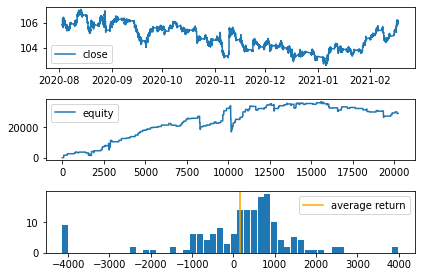

In [65]:
CheckBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
).backtest(from_date=start, to_date=end, filename="backtest.png")

In [ ]:
#total profit        14490.000